In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime
import warnings
import pickle
warnings.filterwarnings('ignore')
% matplotlib inline

In [2]:
from model_generator import *

### Generate df

In [3]:
paths_dict_band = json.load(open('inputs_json/paths_dict_band.json', 'r'))

In [4]:
band = generate_df(paths_dict_band, 'band', '2016')

In [5]:
df = band.return_completed_df()

In [6]:
name_list_24 = ['band']

In [7]:
feature_eng_df = band.return_df_feature_engineering(name_list_24)

In [8]:
band_mean_vol_aemet = pd.read_csv('aemet/band_mean_vol_pred_aemet.csv', encoding='latin1', index_col=0)

In [9]:
final_df = feature_eng_df.merge(band_mean_vol_aemet, how='left', left_index=True, right_index=True)

In [10]:
for feature in ['pred_band_mean_aemet', 'pred_band_vol_aemet']:
    final_df[feature].fillna(method='pad', inplace=True)

In [11]:
lista_df = [element for element in final_df.columns.tolist() if element not in ['hour', 'weekday', 'season', 'band']]

In [12]:
len(lista_df)

70

### Train model

In [ ]:
lgbm_model = train_model(df=final_df, output='band',
                        features_to_remove=['hour', 'weekday', 'season'],
                        n_folds=5, cv_type='normal')

In [ ]:
lgbm_model_grouped = train_model(df=final_df, output='band', features_to_remove=['hour', 'weekday', 'season'],
                                n_folds=5, cv_type='group')

In [24]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
pipeline = LGBMRegressor(num_leaves=60, learning_rate=0.08, n_estimators=1000, seed=0)
pipeline_group = LGBMRegressor(num_leaves=40, learning_rate=0.05, n_estimators=700, seed=0)
p = make_pipeline(Imputer(strategy='median'),
                          RandomForestRegressor(n_estimators=100, max_depth=7, 
                                                max_features='sqrt', max_leaf_nodes=250, 
                                                n_jobs=-1, random_state=0))

In [16]:
lgbm_metamodel = metamodel(features=lista_df, pipeline=pipeline_group, n_folds=5, num_cv=1, cv_type='group',
                          metric={'mae': mean_absolute_error, 'mse':mean_squared_error})

In [17]:
date, oos_lgbm = lgbm_metamodel.get_oos_cv_predictions(x_train=final_df.reset_index(), y_train=final_df['band'],index_col = 'date_hour')

CV number:  1
Acting on fold 1 of 1
Acting on fold 2 of 1
Acting on fold 3 of 1
Acting on fold 4 of 1
Acting on fold 5 of 1
mae on 1 CV: 4.2382 +- 0.5005
mse on 1 CV: 42.6815 +- 20.3380


In [25]:
rf_metamodel = metamodel(features=lista_df, pipeline=p, n_folds=5, num_cv=1, cv_type='group',
                          metric={'mae': mean_absolute_error, 'mse':mean_squared_error})

In [26]:
date, oos_rf = rf_metamodel.get_oos_cv_predictions(x_train=final_df.reset_index(), y_train=final_df['band'],index_col = 'date_hour')

CV number:  1
Acting on fold 1 of 1
Acting on fold 2 of 1
Acting on fold 3 of 1
Acting on fold 4 of 1
Acting on fold 5 of 1
mae on 1 CV: 4.9680 +- 0.5689
mse on 1 CV: 53.8205 +- 19.5181


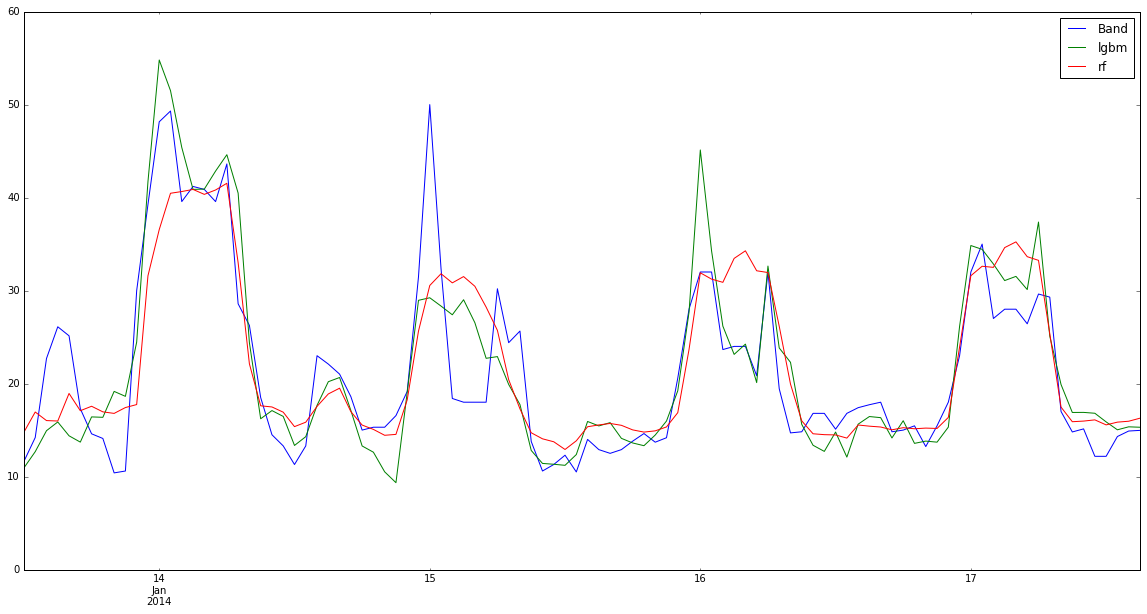

In [31]:
pd.DataFrame({'lgbm': oos_lgbm, 'rf': oos_rf, 'Band':final_df['band']}, index=date).iloc[300:400].plot(figsize=(20,10))

In [ ]:
lgbm_model.obtain_cv_score(pipeline)

In [ ]:
lgbm_model_grouped.obtain_cv_score(pipeline_group)

In [ ]:
lgbm_model.obtain_train_test_error(pipeline)

In [ ]:
lgbm_model_grouped.obtain_train_test_error(pipeline_group)

In [ ]:
lgbm_model.plot_histogram_error()

In [ ]:
lgbm_model_grouped.plot_histogram_error()

In [ ]:
lgbm_model.plot_feature_importance()

In [ ]:
lgbm_model_grouped.plot_feature_importance()

In [ ]:
residuals_model = lgbm_model.get_log_residuals()

In [ ]:
residuals_model_group = lgbm_model_grouped.get_log_residuals()

### Export residuals and model

In [ ]:
with open('models_p/lgbm_band.p', 'wb') as f:
    pickle.dump(lgbm_model.pipeline, f)
    
with open('models_p/lgbm_band_group.p', 'wb') as f:
    pickle.dump(lgbm_model_grouped.pipeline, f)
    
with open('inputs_json/feature_list_band_lgbm.json', 'w') as f:
    json.dump(lgbm_model.features_list, f)
    
residuals_model.to_json('inputs_json/residuals_band_lgbm.json',
                       orient='index', date_format='iso')

residuals_model_group.to_json('inputs_json/residuals_band_lgbm_group.json',
                              orient='index', date_format='iso')